<a href="https://colab.research.google.com/github/pyt-314/MR/blob/main/PolicyGradent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SETUP

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Mon Jun 12 20:14:57 2023

@author: pyt-314
"""

import numpy as np
from collections import deque
import random
import copy
import matplotlib.pyplot as plt

#====[Train Flag]====
train = True

# =============================================================================
# Base class
# =============================================================================

class Layer(object):
    def __init__(self):
        self.params = None
        self.grads = None
    def forward(self,x):
        raise NotImplementedError()
    def backward(self,dy):
        raise NotImplementedError()
    def __call__(self,x):
        return self.forward(x)
    @property
    def Type(self):
        return "Layer"

class Function(object):
    def __init__(self):
        self.x = None
        self.y = None
    def forward(self,x):
        raise NotImplementedError()
    def backward(self,dy):
        raise NotImplementedError()
    def __call__(self,x):
        return self.forward(x)
    @property
    def Type(self):
        return "Function"

class Optimizer(object):
    def __init__(self):
        self.target=[]
    def Add_Target(self,target):
        self.target += list(x for x in target if x.Type =="Layer")
    def Delta(self,gard):
        raise NotImplementedError()
    def updata(self):
        for tg in self.target:
            for i in range(len(tg.params)):
                param = tg.params[i]
                param -= self.Delta(tg.grads[i])

class Model(object):
    def __init__(self):
        "Please make model in list and must include loss with loss fnction"
        self.axis=[]
        self.loss=[]
        self.counter=0
    def forward(self,x,y):
        global train
        train = True
        for lay in self.model[:-1]:
            x = lay(x)
        x = self.model[-1]((x,y))
        self.axis.append(self.counter)
        self.loss.append(x)
        self.counter += 1
        return x
    def backward(self,dx=1):
        for lay in self.model[::-1]:
            dx = lay.backward(dx)
        return dx
    def pred(self,x):
        global train
        train = False
        for lay in self.model[:-1]:
            x = lay(x)
        return x
    def __call__(self,x):
        return self.pred(x)
    def Add_optimizer(self,opt):
        opt.Add_Target(self.model)
    def plot(self):
        plt.plot(self.axis,self.loss)
        plt.show()
    def acc(self,x,y):
        out = self.pred(x)
        sh = y.shape[0]
        acc = np.sum(np.argmax(out, axis=1) == np.argmax(y, axis=1)) / sh
        return acc

# =============================================================================
# For NeuralNetworks
# =============================================================================

class Dense(Layer):
    def __init__(self,w,b):
        super().__init__()
        self.params = (w,b)
        self.grads = (None,None)
        self.x = None
        self.c=0
    def forward(self,x):
        # for input data
        self.x = x
        x = x.reshape(x.shape[0],-1)

        # for parameter
        w,b = self.params
        w_shape = w.shape
        w = w.reshape(w.shape[0],-1)
        b = b.reshape(-1)

        #forward propagation
        out = np.dot(x,w) + b
        out = out.reshape(-1,*w_shape[1:])
        return out
    def backward(self,dy):
        # for input grad
        dy = dy.reshape(dy.shape[0],-1)
        x = self.x.reshape(self.x.shape[0],-1)

        # for paramter
        w,b = self.params
        w_shape = w.shape
        b_shape = b.shape
        w = w.reshape(w_shape[0],-1)
        b = b.reshape(-1)

        # backward propagation
        dx = np.dot(dy,w.T).reshape(self.x.shape)
        dw = np.dot(x.T,dy).reshape(w_shape)
        db = np.sum(dy,axis=0).reshape(b_shape)

        self.grads = (dw,db)
        self.c+=1
        self.dx = dy
        return dx

# for Convolution Networks

def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    N, C, H, W = input_data.shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1
    img = np.pad(input_data, [(0, 0), (0, 0),
                 (pad, pad), (pad, pad)], 'constant')
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))
    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]
    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
    return col


def col2im(col, input_shape, filter_h, filter_w, stride=1, pad=0):
    N, C, H, W = input_shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1
    col = col.reshape(N, out_h, out_w, C, filter_h,
                      filter_w).transpose(0, 3, 4, 5, 1, 2)
    img = np.zeros((N, C, H + 2*pad + stride - 1, W + 2*pad + stride - 1))
    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            img[:, :, y:y_max:stride, x:x_max:stride] += col[:, :, y, x, :, :]
    return img[:, :, pad:H + pad, pad:W + pad]

class Conv2d(Layer):
    def __init__(self, w, b, stride=1, pad=0):
        super().__init__()
        self.params = (w,b)
        self.grads = (None,None)
        self.pad = pad
        self.str = stride

    def forward(self, x):
        w,b = self.params
        fn, C, fh, fw = w.shape
        N, C, H, W = x.shape
        out_h = (H + 2*self.pad - fh)//self.str + 1
        out_w = (W + 2*self.pad - fw)//self.str + 1
        x1 = im2col(x, fh, fw, self.str, self.pad)
        w = w.reshape(fn, -1).T
        x2 = np.dot(x1, w) + b
        out = x2.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)
        self.x1 = x1.copy()
        self.x = x
        return out

    def backward(self, grad):
        w,b = self.params
        fn, C, fh, fw = w.shape
        dx3 = grad.transpose(0, 2, 3, 1).reshape(fn, -1).T
        w = w.reshape(fn, -1).T
        dx2 = np.dot(dx3, w.T)
        dw = np.dot(self.x1.T, dx3)
        db = np.sum(dx3, axis=0)
        self.grads = (dw,db)
        dx1 = col2im(dx2, self.x.shape, fh, fw, self.str, self.pad)
        return dx1

class max_pooling(Function):
    def __init__(self, pool_x, pool_y ,stride):
        self.dx = None
        self.x = None
        self.mask = None
        self.strx = pool_x
        self.stry = pool_y
        self.str = stride
    def forward(self, x):
        N,C,H,W = x.shape
        self.x = x
        out_y = (H - self.stry)//self.str + 1
        out_x = (W - self.strx)//self.str + 1
        self.ox,self.oy = out_x,out_y
        x1 = im2col(x, self.stry, self.stry ,self.str).reshape(-1,self.stry*self.strx)
        self.x1 = x1
        mask = np.argmax(x1, axis=1)
        self.mask = mask
        out = x1[np.arange(0,mask.size),mask]
        out = out.reshape(N,out_y,out_x,C).transpose(0,3,1,2)
        return out
    def backward(self, grad):
        grad1 = grad.transpose(0,2,3,1).flatten()
        grad2 = np.zeros((grad1.size,self.strx*self.stry))
        grad2[:,self.mask.flatten()] = grad1
        grad_img = col2im(grad2,self.x.shape,self.stry,self.strx,self.str)
        return grad_img

class average_pooling(Function):
    def __init__(self, pool_x, pool_y ,stride):
        self.dx = None
        self.x = None
        self.mask = None
        self.strx = pool_x
        self.stry = pool_y
        self.str = stride
    def forward(self, x):
        N,C,H,W = x.shape
        self.x = x
        out_y = (H - self.stry)//self.str + 1
        out_x = (W - self.strx)//self.str + 1
        self.ox,self.oy = out_x,out_y
        x1 = im2col(x, self.stry, self.stry ,self.str).reshape(-1,self.stry*self.strx)
        self.x1 = x1
        mask = np.argmax(x1, axis=1)
        self.mask = mask
        out = np.mean(x1,axis=1)
        out = out.reshape(N,out_y,out_x,C).transpose(0,3,1,2)
        return out
    def backward(self, grad):
        grad1 = grad.transpose(0,2,3,1).flatten()
        grad2 = np.zeros((grad1.size,self.strx*self.stry))
        grad2[:] = grad1.reshape(-1,1).repeat(self.strx*self.stry,axis=1)/self.strx*self.stry
        grad_img = col2im(grad2,self.x.shape,self.stry,self.strx,self.str)
        return grad_img

# Activation Function

class Relu(Function):
    def __init__(self):
        self.mask = None
    def forward(self,x):
        self.mask = x>0
        return self.mask*x
    def backward(self,dy):
        return self.mask*dy

class Sigmoid(Function):
    def __init__(self):
        self.y = None
    def forward(self,x):
        self.y = 1/(np.exp(-x)+1)
        return self.y
    def backward(self,dy):
        return self.y*(1-self.y)*dy

class Softmax(Function):
    def __init__(self,temp=1,axis=1):
        self.dx = None
        self.temp = temp
        self.axis=axis
    def forward(self, x):
        x = x - np.max(x, axis=self.axis,keepdims=1)
        self.out = np.exp(x*self.temp)/np.sum(np.exp(x*self.temp), axis=self.axis, keepdims=True)
        return self.out
    def backward(self, dy):
        dx = self.out * dy
        sums = np.sum(dx, axis=self.axis, keepdims=True)
        dx -= self.out * sums
        return dx * self.temp

class DropOut(Function):
    def __init__(self,rate):
        self.rate = rate
        self.mask = None
    def forward(self,x):
        global train
        if train == True:
            self.mask = np.random.rand(x.shape)<self.rate
            return self.mask * x
        else:
            return x/self.rate
    def backward(self,dy):
        return self.mask*dy

class RV_DropOut(Function):
    def __init__(self,rate):
        self.rate = rate
    def forward(self,x):
        global train
        if train:
            self.mask = np.random.rand(x.shape)<self.rate
            return self.mask * x/self.rate
        else:
            return x
    def backward(self,dy):
        return self.mask *dy

class Faltten(Function):
    def __init__(self):
        pass
    def forward(self,x):
        self.shape = x.shape
        return x.reshape(self.shape[0],-1)
    def backward(self,dy):
        return dy.reshape(self.shape)

class Slice(Function):
    def __init__(self):
        self.mask = None
    def forward(self,x):
        x,mask = x
        self.mask = mask
        self.x_shape=x.shape
        return x[mask]
    def backward(self,dx):
        grad = np.zeros(self.x_shape)
        grad[self.mask]=dx
        return grad

class Log(Function):
    def __init__(self):
        self.x = None
    def forward(self,x):
        self.x = x
        return np.log(x)
    def backward(self,dy):
        return 1/self.x*dy
# Loss Function

class MSE(Function):
    def __init__(self):
        pass
    def forward(self,x):
        x,self.ans = x
        self.a = self.ans-x
        return np.sum(self.ans**2)/x.shape[0]
    def backward(self,dy=1):
        return -self.a/self.a.shape[0]*dy

#========sub=========
def softmax(x,temp):
    out = np.exp((x-np.max(x, axis=1, keepdims=True))*temp)/(
            np.sum(np.exp((x-np.max(x, axis=1, keepdims=True))*temp), axis=1, keepdims=True))
    return out
#=======END=========

class ClossEnt(Function):
    def __init__(self,temp=1):
        self.temp = temp
    def forward(self,x):
        x,self.ans = x
        self.a = softmax(x,self.temp)
        out = np.sum(-self.ans*np.log(self.a+10e-10))/len(x)
        return out
    def backward(self,dy=1):
        return (self.a-self.ans)/len(self.a)*self.temp

#[===Optimizer===]
class SGD(Optimizer):
    def __init__(self,lr):
        super().__init__()
        self.lr = lr
    def Delta(self,grad):
        return grad*self.lr

# =============================================================================
# The End of Neural Network Layers
# Deep Q Network
# =============================================================================

class Replay_Buffer:
    def __init__(self,batchs,max_len):
        """
        for Deep Q Network
        """
        self.buffer = deque(maxlen=max_len)
        self.batchs = batchs
    def __len__(self):
        return len(self.buffer)
    def add(self,*data):
        self.buffer.append(data)
    def get(self):
        data = random.sample(self.buffer, k=self.batchs)

        sta = np.stack(x[0] for x in data)
        act = np.array(x[1] for x in data)
        rew = np.array(x[2] for x in data)
        nex = np.stack(x[3] for x in data)
        don = np.array(x[4] for x in data).astype(bool)
        return sta,act,rew,nex,don

class QNet_Model(Model):
    def Compile(self):
        self.model.append(Slice())
        self.model.append(MSE())
    def forward(self,x,a,y):
        for lay in self.model[:-2]:
            x = lay(x)
        q = self.model[-2]((x,a))
        loss = self.model[-1]((q,y))
        return loss
    def backward(self,dx=1):
        dx = self.model[-1].backward(dx)
        dx = self.model[-2].backward(dx)
        for lay in self.model[:-2][::-1]:
            dx = lay.backward(dx)
        return dx


class DQN:
    def __init__(self,mod,opt,
                 act_size,
                 gamma=0.98,
                 epsilon=0.1,
                 buffer=10000,
                 batchs=32):
        self.model = mod.append(MSE())
        self.opt = opt
        self.gamma = gamma
        self.epsil = epsilon
        self.buffer = Replay_Buffer(batchs, buffer)
        self.act_size=act_size
        self.batchs = batchs
        self.Q_ter = None
    def copy_NET(self):
        self.Q_ter = copy.deepcopy(self.model)
    def Get(self,sta):
        if np.random.rand()<self.epsil:
            return np.eye(self.act_size)[np.random.randint(0,self.act_size-1)]
        else:
            sta = sta[None,:]
            act = self.model(sta)
            return np.argmax(act,axis=1)
    def updata(self,data):
        self.buffer.add(data)
        if len(self.buffer)>=self.batchs:
            return None
        sta,act,rew,nex,don = self.buffer.get()
        next_Qs = self.Q_ter(nex)
        nexQ = np.max(next_Qs,axis=1)
        target = rew + (1-don)*self.gamma*nexQ
        self.model.forward(sta,act,target)
        self.model.backward()
        self.opt.updata()

In [2]:
!pip install gym[classic_control]
import matplotlib.pyplot as plt

# utility functions (common functions)
def plot_total_reward(reward_history):
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.plot(range(len(reward_history)), reward_history)
    plt.show()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 53.2 MB/s eta 0:00:00
  Attempting uninstall: pygame
    Found existing installation: pygame 2.3.0
    Uninstalling pygame-2.3.0:
      Successfully uninstalled pygame-2.3.0


# train

In [8]:
class value_net(Model):
    def __init__(self):
        self.loss = MSE()
    def forward(self, x):
        for lay in self.model:
            x = lay(x)
        self.x = x
        return x
    def Loss(self,y):
        loss = self.loss((self.x,y))
        return loss
    def backward(self,dx=1):
        dx = self.loss.backward(dx)
        for lay in reversed(self.model):
            dx = lay.backward(dx)
        return dx
    def __call__(self,x):
        return self.forward(x)

class policy_net(Model):
    def __init__(self):
        pass
    def forward(self,x):
        for lay in self.model:
            x = lay(x)
            #print(x)
        return x
    def backward(self,dx=1):
        for lay in reversed(self.model):
            #print(dx)
            dx = lay.backward(dx)
        return dx
    def __call__(self,x):
        return self.forward(x)

class ActorCritic:
    def __init__(self,PolicyNet,
                 ValueNet,
                 opt1,
                 opt2,
                 gamma=0.98):
        self.model = PolicyNet
        self.Val = ValueNet
        self.opt1 = opt1
        self.opt2 = opt2
        self.gamma = gamma
        self.log = Log()
        self.sli = Slice()
    def get_act(self,state):
        state = state[None,:]
        act = self.model(state)
        act = act[0]
        act1 = np.random.choice(len(act),p=act)
        return act1,self.sli((act,act1))
    def update(self,state,act_p,reward,next_state,done):
        state = state[None,:]
        next_state = next_state[None,:]

        target = reward + self.gamma * self.Val(next_state) * (1-done)
        v = self.Val(state)
        self.Val.Loss(target)
        self.Val.backward()

        delta = target-v
        loss_pi = -self.log(act_p)*delta

        self.model.backward(dx=self.sli.backward(dx=-delta/act_p))
        #print(self.log.backward(-delta))
        self.opt1.updata()
        self.opt2.updata()


episode :0, total reward : 10.0
episode :100, total reward : 10.0
episode :200, total reward : 85.0
episode :300, total reward : 80.0
episode :400, total reward : 86.0
episode :500, total reward : 179.0
episode :600, total reward : 113.0
episode :700, total reward : 117.0
episode :800, total reward : 41.0
episode :900, total reward : 38.0
episode :1000, total reward : 200.0
episode :1100, total reward : 149.0
episode :1200, total reward : 200.0
episode :1300, total reward : 200.0
episode :1400, total reward : 200.0
episode :1500, total reward : 200.0
episode :1600, total reward : 200.0
episode :1700, total reward : 200.0
episode :1800, total reward : 177.0
episode :1900, total reward : 115.0
episode :2000, total reward : 129.0
episode :2100, total reward : 194.0
episode :2200, total reward : 156.0
episode :2300, total reward : 200.0
episode :2400, total reward : 200.0
episode :2500, total reward : 200.0
episode :2600, total reward : 200.0
episode :2700, total reward : 173.0
episode :28

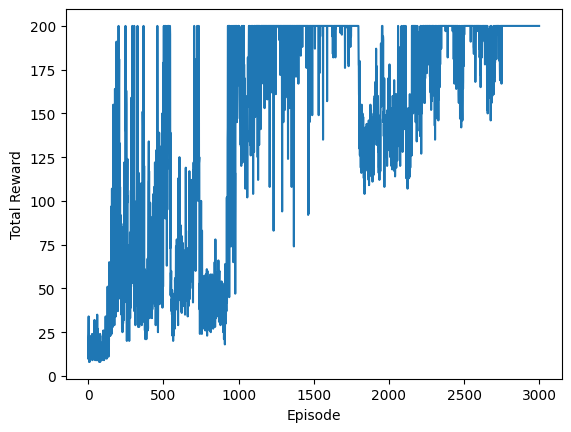

In [12]:
import gym
import numpy as np

class PN(policy_net):
    def __init__(self):
        node = 128
        out = 2
        w1 = np.random.randn(4,node)/np.sqrt(node)
        b1 = np.zeros(node)
        w2 = np.random.randn(node,out)/np.sqrt(out)
        b2 = np.zeros(out)
        self.model = (Dense(w1,b1),
                      Relu(),
                      Dense(w2,b2),
                      Softmax())

class VN(value_net):
    def __init__(self):
        super().__init__()
        node = 128
        w1,b1 = np.random.randn(4,node)/np.sqrt(node),np.zeros(node)
        w2,b2 = np.random.randn(node,1),np.zeros(1)
        self.model = (Dense(w1,b1),
                      Relu(),
                      Dense(w2,b2))

lr = 0.0002
episodes = 3000
env = gym.make('CartPole-v0')
po = PN()
va = VN()
opt1 = SGD(lr)
opt2 = SGD(lr)
po.Add_optimizer(opt1)
va.Add_optimizer(opt2)
agent = ActorCritic(po,va,opt1,opt2)
reward_history=[]
for episode in range(episodes):
    state = env.reset()
    done = False
    total_reward = 0

    while not done:
        action, prob = agent.get_act(state)
        next_state, reward, done, info = env.step(action)

        agent.update(state, prob, reward, next_state, done)

        state = next_state
        total_reward += reward
    reward_history.append(total_reward)
    if episode % 100 == 0:
        print("episode :{}, total reward : {:.1f}".format(episode, total_reward))
# plot
plot_total_reward(reward_history)

In [ ]:
SOFTMAX = Softmax()
a = np.random.randn(10,2)
b = SOFTMAX(a)
print(np.sum(b[3]))
print(b[3])
print(SOFTMAX.backward(1))
b.data

1.0
[0.38119428 0.61880572]
[[0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]
 [1.11022302e-16 1.38777878e-17]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
print(agent.model.model[2])
print(agent.get_act(state))
print(agent.model.model[2].x)
agent.model.backward()
agent.model.model[2].dx
#opt1.target

(1, 0.33923083789479846)
[[ 4.27660528e-02 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  -0.00000000e+00  9.56703862e-02  2.89254822e-02  4.20347459e-01
  -0.00000000e+00 -0.00000000e+00  2.10979186e-01  5.83879221e-01
   1.28921341e-01 -0.00000000e+00  3.96984874e-01  6.13084515e-01
   2.84628662e-01 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
   7.44397044e-01 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  -0.00000000e+00 -0.00000000e+00  4.33023766e-01 -0.00000000e+00
  -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  1.76506037e-01
   3.29993764e-01  4.14869810e-02 -0.00000000e+00 -0.00000000e+00
  -0.00000000e+00  3.21666031e-03 -0.00000000e+00 -0.00000000e+00
  -0.00000000e+00 -0.00000000e+00  6.21339003e-02  5.23098570e-02
  -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  -0.00000000e+00 -0.00000000e+00  2.34209062e-01 -0.00000000e+00
   3.81530576e-01  2.56941695e-01  6.97937126e-02 -

array([[1.11022302e-16, 5.55111512e-17]])

In [ ]:
agent.update(state, prob, reward, next_state, done)
